## Task 1.1

In [38]:
import pickle
import networkx as nx
from pathlib import Path

data_path = Path("../data")
pkl_path = data_path / "network_data.pkl"

# 1. 载入之前存的 MultiDiGraph G
with open(pkl_path, "rb") as f:
    G = pickle.load(f)

print(G)  # 看一眼类型和节点/边数
print("MultiDiGraph nodes:", G.number_of_nodes())
print("MultiDiGraph edges:", G.number_of_edges())

# 2. 提取 retweet / reply 的边（账号-账号）
retweet_edges = []
reply_edges = []

for u, v, attrs in G.edges(data=True):
    edge_type = attrs.get("type")
    if edge_type == "retweet":
        retweet_edges.append((u, v, attrs))
    elif edge_type == "reply":
        reply_edges.append((u, v, attrs))

print("Retweet edges:", len(retweet_edges))
print("Reply edges  :", len(reply_edges))


MultiDiGraph with 1936 nodes and 23220 edges
MultiDiGraph nodes: 1936
MultiDiGraph edges: 23220
Retweet edges: 19168
Reply edges  : 4052


In [2]:
# 从 MultiDiGraph → 简单无向图（为这次 lab 做准备）
# 3. 建 retweet 的简单无向图
G_rt_nx = nx.Graph()  # 无向、自动合并多重边
G_rt_nx.add_nodes_from(G.nodes(data=True))  # 把节点属性也拷过去
# 只加 retweet 边（忽略方向，只要一条无向边）
for u, v, attrs in retweet_edges:
    G_rt_nx.add_edge(u, v, **attrs)

print("Retweet NX graph:", G_rt_nx.number_of_nodes(), "nodes,", G_rt_nx.number_of_edges(), "edges")

# 4. 建 reply 的简单无向图
G_rp_nx = nx.Graph()
G_rp_nx.add_nodes_from(G.nodes(data=True))
for u, v, attrs in reply_edges:
    G_rp_nx.add_edge(u, v, **attrs)

print("Reply NX graph  :", G_rp_nx.number_of_nodes(), "nodes,", G_rp_nx.number_of_edges(), "edges")


Retweet NX graph: 1936 nodes, 6325 edges
Reply NX graph  : 1936 nodes, 733 edges


In [4]:
import igraph as ig

def nx_to_igraph_undirected(G_nx: nx.Graph) -> ig.Graph:
    """
    把一个 NetworkX 无向图转换成 iGraph 图。
    保留节点属性（包括 author_id/user_type/lang/stance），
    边属性（retweet_count, like_count...）也可以一起拷贝。
    """
    # 1) 确保节点有一个“name”属性给 igraph 用
    #    这里我们把节点本身的 ID（author_id 字符串）作为 name
    nodes = list(G_nx.nodes())
    id_to_idx = {node_id: idx for idx, node_id in enumerate(nodes)}

    # 2) 建 iGraph 图
    g = ig.Graph(n=len(nodes), directed=False)
    g.vs["name"] = [str(n) for n in nodes]

    # 3) 拷贝节点属性
    # 检查一个节点有哪些属性
    sample_attrs = next(iter(G_nx.nodes(data=True)))[1].keys()
    for attr in sample_attrs:
        g.vs[attr] = [G_nx.nodes[n].get(attr) for n in nodes]

    # 4) 拷贝边（及其属性）
    edges = []
    edge_attrs_dict = {}  # attr_name -> list
    # 先找出所有 edge 属性名字
    sample_edge = next(iter(G_nx.edges(data=True)))[2]
    edge_attr_names = list(sample_edge.keys())

    for u, v, attrs in G_nx.edges(data=True):
        edges.append((id_to_idx[u], id_to_idx[v]))
        for attr in edge_attr_names:
            edge_attrs_dict.setdefault(attr, []).append(attrs.get(attr))

    g.add_edges(edges)
    # 把所有 edge 属性挂上去
    for attr, values in edge_attrs_dict.items():
        g.es[attr] = values

    return g

# 应用到 retweet / reply 图
g_rt = nx_to_igraph_undirected(G_rt_nx)
g_rp = nx_to_igraph_undirected(G_rp_nx)

print(g_rt.summary())
print(g_rp.summary())


IGRAPH UN-- 1936 6325 -- 
+ attr: lang (v), name (v), stance (v), user_type (v), like_count (e), quote_count (e), reply_count (e), retweet_count (e), type (e)
IGRAPH UN-- 1936 733 -- 
+ attr: lang (v), name (v), stance (v), user_type (v), like_count (e), quote_count (e), reply_count (e), retweet_count (e), type (e)


1936 个节点，6325 条边；

+ attr: lang (v), name (v), stance (v), user_type (v), like_count (e), quote_count (e), reply_count (e), retweet_count (e), type (e)

节点有 4 种属性（语言、name、立场、类型）

边有 5 种属性（互动计数 + type）

In [ ]:
# 按照lab 里的tips: 简化图（合并多重边、自环）
# 这里 multiple=True 和 loops=True 是默认值，其实可以直接 g_rt.simplify()
g_rt_simpl = g_rt.simplify()
g_rp_simpl = g_rp.simplify()

print("=== After simplify() ===")
print("Retweet:", g_rt_simpl.summary())
print("Reply  :", g_rp_simpl.summary())

# 之后建议都用这俩变量继续分析
g_rt = g_rt_simpl
g_rp = g_rp_simpl


=== After simplify() ===
Retweet: IGRAPH UN-- 1936 6325 -- 
+ attr: lang (v), name (v), stance (v), user_type (v)
Reply  : IGRAPH UN-- 1936 611 -- 
+ attr: lang (v), name (v), stance (v), user_type (v)


## Task 1.2

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_graph(g: ig.Graph, name="graph", plot_degree_dist=True):
    print(f"=== Summary for {name} ===")
    
    # 1) 基本结构
    n = g.vcount()
    m = g.ecount()
    print(f"Order (nodes): {n}")
    print(f"Size  (edges): {m}")
    
    # 2) 连通分量
    comps = g.components()  # 或 g.clusters()
    num_comps = len(comps)
    largest_comp_size = max(len(c) for c in comps)
    print(f"Number of components: {num_comps}")
    print(f"Largest component size: {largest_comp_size} "
          f"({largest_comp_size/n:.2%} of all nodes)")
    
    # 3) 密度
    density = g.density()
    print(f"Density: {density:.6f}")
    
    # 4) 聚类系数 / transitivity
    transitivity = g.transitivity_undirected()
    print(f"Global clustering (transitivity): {transitivity:.6f}")
    
    # 5) 度的基本统计
    degrees = g.degree()
    deg_arr = np.array(degrees)
    print(f"Degree: min={deg_arr.min()}, "
          f"mean={deg_arr.mean():.2f}, "
          f"max={deg_arr.max()}")
    
    # 6) 可选：在最大连通分量上算平均路径长度（全图可能断开）
    #    这不是 Task 1.2 强制要求，但对理解有帮助，可以保留/注释
    try:
        giant = comps.giant()  # 最大连通分量子图
        avg_path_len = giant.average_path_length()
        print(f"Average path length (giant component): {avg_path_len:.3f}")
    except Exception as e:
        print("Could not compute average path length:", e)
    
    # 7) 度分布 log–log 图
    if plot_degree_dist:
        # 统计：每个度值出现多少次
        unique_deg, counts = np.unique(deg_arr, return_counts=True)
        
        # 去掉度为 0 的点（否则 log-log 上没法显示）
        mask = unique_deg > 0
        unique_deg = unique_deg[mask]
        counts = counts[mask]
        
        # 使用频率（概率）而不是绝对计数
        probs = counts / counts.sum()
        
        plt.figure(figsize=(5, 4))
        plt.loglog(unique_deg, probs, marker='o', linestyle='none')
        plt.xlabel("Degree k (log scale)")
        plt.ylabel("P(k) (log scale)")
        plt.title(f"Degree distribution (log-log) - {name}")
        plt.grid(True, which="both", ls="--", alpha=0.3)
        plt.show()
    
    print()  # 空行分隔


=== Summary for Retweet network ===
Order (nodes): 1936
Size  (edges): 6325
Number of components: 1013
Largest component size: 921 (47.57% of all nodes)
Density: 0.003377
Global clustering (transitivity): 0.115361
Degree: min=0, mean=6.53, max=374
Average path length (giant component): 2.793


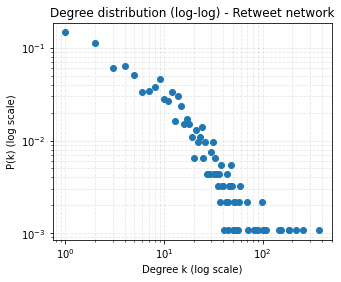


=== Summary for Reply network ===
Order (nodes): 1936
Size  (edges): 611
Number of components: 1544
Largest component size: 378 (19.52% of all nodes)
Density: 0.000326
Global clustering (transitivity): 0.017934
Degree: min=0, mean=0.63, max=88
Average path length (giant component): 3.563


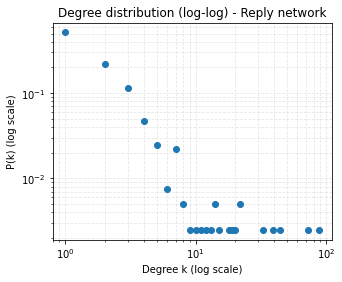

In [7]:
summarize_graph(g_rt, name="Retweet network")
summarize_graph(g_rp, name="Reply network")

## Task 1.3

In [24]:
output_dir = Path("../output")  
output_dir.mkdir(exist_ok=True)

def plot_network(g, layout, name="network", filename=None):
    # 顶点与边颜色
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"   # 简单颜色，避免 rgba 兼容性问题

    if filename is None:
        filename = output_dir / f"{name}_nodelink.png"
    else:
        filename = Path(filename)

    print(f"Saving plot to: {filename}")

    # 创建 matplotlib figure / axes
    fig, ax = plt.subplots(figsize=(8, 8))

    # 关键：target=ax  → igraph 使用 matplotlib 后端，而不是 Cairo
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=3,
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )

    # 用 matplotlib 保存
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)


In [25]:
# 只算一次 layout，之后复用
layout_rt = g_rt.layout_fruchterman_reingold()
layout_rp = g_rp.layout_fruchterman_reingold()

plot_network(g_rt, layout_rt, name="retweet_network")
plot_network(g_rp, layout_rp, name="reply_network")

Saving plot to: ../output/retweet_network_nodelink.png
Saving plot to: ../output/reply_network_nodelink.png


## Task 1.4

In [27]:
def degree_to_sizes(g, min_size=3, max_size=20):
    """
    根据整个图中所有节点的度生成 vertex_size 数组。
    使用 log 缩放避免超级 hub 把其他点压扁。
    """
    deg = np.array(g.degree())      # 👈 所有节点的 degree
    log_deg = np.log1p(deg)         # log(1 + k)

    if log_deg.max() == log_deg.min():
        sizes = np.full_like(log_deg, (min_size + max_size) / 2.0, dtype=float)
    else:
        norm = (log_deg - log_deg.min()) / (log_deg.max() - log_deg.min())
        sizes = min_size + norm * (max_size - min_size)

    return sizes.tolist()


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import igraph as ig

output_dir = Path("../output")
output_dir.mkdir(exist_ok=True)

def plot_network_with_sizes(g, layout, sizes, name="network"):
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"

    filename = output_dir / f"{name}_degree.png"
    print(f"Saving plot to: {filename}")

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=sizes,        
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)


## Task 1.5

In [44]:
def betweenness_exact(g):
    """
    Compute exact betweenness centrality for all nodes.
    Uses igraph's built-in Brandes algorithm.
    
    Parameters
    ----------
    g : igraph.Graph
        The network graph (undirected, unweighted).
    
    Returns
    -------
    list of float
        Betweenness centrality values for all nodes.
    """
    print("Using EXACT betweenness (igraph Brandes algorithm)...")
    bw = g.betweenness(directed=False, weights=None)
    return bw

In [46]:
import random

def betweenness_approx_sampled(g, nsamples=200, seed=0):
    """
    近似 betweenness：
    - 随机选 nsamples 个源节点
    - 对每个源节点运行一轮 Brandes 单源算法
    - 把结果累加并按采样比例缩放
    适用于无向、无权图。
    返回：长度 = g.vcount() 的列表
    """
    random.seed(seed)
    n = g.vcount()
    vertices = list(range(n))
    ns = min(nsamples, n)
    sources = random.sample(vertices, ns)

    bw = np.zeros(n, dtype=float)
    neighbors = [g.neighbors(v) for v in range(n)]  # 提前取好邻居，加速一点

    for s in sources:
        # Brandes 单源部分（无权图）
        S = []                      # stack
        P = [[] for _ in range(n)]  # 前驱
        sigma = [0.0] * n           # 最短路径条数
        sigma[s] = 1.0
        d = [-1] * n                # 距离
        d[s] = 0
        Q = [s]                     # BFS 队列

        while Q:
            v = Q.pop(0)
            S.append(v)
            for w in neighbors[v]:
                if d[w] < 0:        # w 首次被发现
                    Q.append(w)
                    d[w] = d[v] + 1
                if d[w] == d[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v)

        # 依赖回传
        delta = [0.0] * n
        while S:
            w = S.pop()
            for v in P[w]:
                if sigma[w] > 0:
                    delta_v = (sigma[v] / sigma[w]) * (1.0 + delta[w])
                    delta[v] += delta_v
            if w != s:
                bw[w] += delta[w]

    # 按采样比例缩放（粗略校正一下）
    factor = float(n) / float(ns)
    bw *= factor
    print("Using APPROXIMATE betweenness (sampling)...")
    return bw.tolist()

In [47]:
# Reply：节点少、边少，用精确版没问题
bw_rp = betweenness_exact(g_rp)

# Retweet：用我们刚写的采样近似版
bw_rt = betweenness_approx_sampled(g_rt, nsamples=300, seed=42)

Using EXACT betweenness (igraph Brandes algorithm)...
Using APPROXIMATE betweenness (sampling)...


In [ ]:
# 验证近似是否靠谱:
bw_rp_exact = betweenness_exact(g_rp)
bw_rp_approx = betweenness_approx_sampled(g_rp, nsamples=300, seed=42)

bw_rp_exact_arr = np.array(bw_rp_exact)
bw_rp_approx_arr = np.array(bw_rp_approx)

corr = np.corrcoef(bw_rp_exact_arr, bw_rp_approx_arr)[0, 1]
print("Correlation between exact & approx on Reply:", corr)

top10_exact  = set(bw_rp_exact_arr.argsort()[-10:])
top10_approx = set(bw_rp_approx_arr.argsort()[-10:])
print("Top-10 overlap:", len(top10_exact & top10_approx), "/ 10")


Using EXACT betweenness (igraph Brandes algorithm)...
Using APPROXIMATE betweenness (sampling)...
Correlation between exact & approx on Reply: 0.9853548980738237
Top-10 overlap: 7 / 10


In [49]:
# 画图
import numpy as np

def centrality_to_sizes(values, min_size=3, max_size=20):
    """
    把中心性数组（degree, betweenness, ...）映射到合适的点大小区间。
    使用 log 缩放避免极端值。
    values: 1D 数组或列表（长度 = 节点数）
    """
    vals = np.array(values, dtype=float)
    # 先把负值（万一有）抬到 >= 0
    vals = vals - vals.min()
    log_vals = np.log1p(vals)  # log(1 + x)

    if log_vals.max() == log_vals.min():
        # 所有值都一样的极端情况
        return np.full_like(log_vals, (min_size + max_size) / 2.0, dtype=float).tolist()
    else:
        norm = (log_vals - log_vals.min()) / (log_vals.max() - log_vals.min())
        sizes = min_size + norm * (max_size - min_size)
        return sizes.tolist()


In [50]:
# 1) 把 betweenness 映射到点大小
sizes_rp_bw = centrality_to_sizes(bw_rp, min_size=2, max_size=20)
sizes_rt_bw = centrality_to_sizes(bw_rt, min_size=2, max_size=20)

# 2) 假设你已经有 layout_rt, layout_rp（Task 1.3 时算过）
# layout_rt = g_rt.layout_fruchterman_reingold()
# layout_rp = g_rp.layout_fruchterman_reingold()

def plot_network_with_sizes(g, layout, sizes, name="network", suffix="betweenness"):
    g.vs["color"] = "steelblue"
    g.es["color"] = "lightgrey"

    filename = output_dir / f"{name}_{suffix}.png"
    print(f"Saving plot to: {filename}")

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
        g,
        layout=layout,
        target=ax,
        bbox=(800, 800),
        margin=40,
        vertex_size=sizes,
        vertex_frame_width=0,
        vertex_label=None,
        edge_width=0.2,
    )
    fig.savefig(filename, dpi=150, bbox_inches="tight")
    plt.close(fig)

# 3) 在“全图”的所有节点上画 betweenness 图
plot_network_with_sizes(g_rt, layout_rt, sizes_rt_bw,
                        name="retweet_network", suffix="betweenness")
plot_network_with_sizes(g_rp, layout_rp, sizes_rp_bw,
                        name="reply_network", suffix="betweenness")


Saving plot to: ../output/retweet_network_allnodes_betweenness.png
Saving plot to: ../output/reply_network_allnodes_betweenness.png


## Task 1.6

In [51]:
import pandas as pd
import numpy as np

# Degree（所有节点）
deg_rt = np.array(g_rt.degree())
deg_rp = np.array(g_rp.degree())

# Betweenness（我们之前已经算好了）
# bw_rt = betweenness_approx_sampled(g_rt, nsamples=300, seed=42)
# bw_rp = betweenness_exact(g_rp)

def get_top_indices(values, n=10):
    """返回中心性最高的节点索引（降序）"""
    return np.argsort(values)[-n:][::-1]

top10_deg_rt_idx = get_top_indices(deg_rt)
top10_deg_rp_idx = get_top_indices(deg_rp)
top10_bw_rt_idx  = get_top_indices(bw_rt)
top10_bw_rp_idx  = get_top_indices(bw_rp)

# 取出对应的 actor_id（igraph 的 vertex 属性里有）
top10_deg_rt_ids = [g_rt.vs[i]["name"] for i in top10_deg_rt_idx]
top10_deg_rp_ids = [g_rp.vs[i]["name"] for i in top10_deg_rp_idx]
top10_bw_rt_ids  = [g_rt.vs[i]["name"] for i in top10_bw_rt_idx]
top10_bw_rp_ids  = [g_rp.vs[i]["name"] for i in top10_bw_rp_idx]

print("Top 10 by DEGREE (Retweet):", top10_deg_rt_ids)
print("Top 10 by DEGREE (Reply):  ", top10_deg_rp_ids)
print("Top 10 by BETWEENNESS (Retweet):", top10_bw_rt_ids)
print("Top 10 by BETWEENNESS (Reply):  ", top10_bw_rp_ids)

Top 10 by DEGREE (Retweet): ['17463923', '2617471956', '4010449719', '14159148', '247637778', '389548615', '243236419', '38146999', '3584633117', '21866534']
Top 10 by DEGREE (Reply):   ['2617471956', '389548615', '2381085919', '2365497828', '26207020', '2784989480', '1476593672', '17463923', '243236419', '69032746']
Top 10 by BETWEENNESS (Retweet): ['17463923', '2617471956', '247637778', '4010449719', '14159148', '243236419', '389548615', '2482232082', '69032746', '3584633117']
Top 10 by BETWEENNESS (Reply):   ['2617471956', '389548615', '2381085919', '2365497828', '26207020', '243236419', '2784989480', '69032746', '17463923', '1591198093']


In [56]:
# 读取账号信息
accounts_df = pd.read_csv("../data/accounts.tsv", sep="\t", dtype={"author_id": str})


In [58]:
def describe_top_accounts(ids, accounts_df, label):
    df = accounts_df[accounts_df["author_id"].isin(ids)]
    print(f"\n=== {label} ===")
    if df.empty:
        print("None of these top accounts are in the annotated producers list.")
    else:
        print(df[["author_id", "Type", "Lang", "Stance"]])
        print(f"→ {len(df)} / {len(ids)} accounts matched annotated producers")

describe_top_accounts(top10_deg_rt_ids, accounts_df, "Retweet – Top 10 by Degree")
describe_top_accounts(top10_bw_rt_ids,  accounts_df, "Retweet – Top 10 by Betweenness")
describe_top_accounts(top10_deg_rp_ids, accounts_df, "Reply – Top 10 by Degree")
describe_top_accounts(top10_bw_rp_ids,  accounts_df, "Reply – Top 10 by Betweenness")



=== Retweet – Top 10 by Degree ===
       author_id                 Type Lang   Stance
346    243236419  Private individuals   en      For
393     21866534      Advocacy actors   en      For
457   2617471956     Political actors   fr  Unclear
459   4010449719     Political actors   en  Unclear
1250   389548615  Private individuals   en      For
1570  3584633117      Advocacy actors   en      For
1585   247637778  Private individuals   fr      For
1705    17463923      Advocacy actors   en      For
1710    38146999     Political actors   en      For
1750    14159148     Political actors   en      For
→ 10 / 10 accounts matched annotated producers

=== Retweet – Top 10 by Betweenness ===
       author_id                 Type Lang   Stance
7     2482232082     Political actors   es  Unclear
346    243236419  Private individuals   en      For
457   2617471956     Political actors   fr  Unclear
459   4010449719     Political actors   en  Unclear
1250   389548615  Private individuals   en  

## Task 1.7 (Retweet Network)

In [59]:
# 选取 retweet network
g = g_rt

# 找到所有连通分量
components = g.components()

print(f"Number of components: {len(components)}")
sizes = [len(c) for c in components]
print(f"Largest component size: {max(sizes)}")

# 提取最大连通分量 (giant component)
giant = components.giant()
print(giant.summary())


Number of components: 1013
Largest component size: 921
IGRAPH UN-- 921 6321 -- 
+ attr: color (v), lang (v), name (v), stance (v), user_type (v), color (e)


=== Summary for Retweet network – Largest component ===
Order (nodes): 921
Size  (edges): 6321
Number of components: 1
Largest component size: 921 (100.00% of all nodes)
Density: 0.014920
Global clustering (transitivity): 0.115354
Degree: min=1, mean=13.73, max=374
Average path length (giant component): 2.793


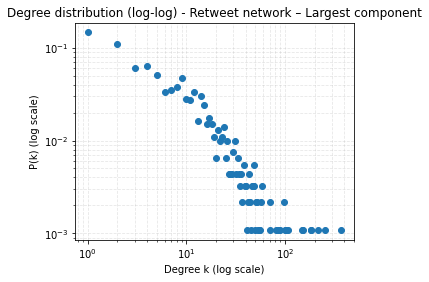

In [60]:
summarize_graph(giant, name="Retweet network – Largest component")